# Chain

A simple chain that combines 4 concepts

* Using chat messages as our graph state
* Using chat models in graph nodes
* Binding tools to our chat model
* Executing tool calls

## Messages

* LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

In [23]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

# Create a message
messages = [AIMessage(content=f"so you are talking about Artificial Intelligence!", name ="Model")]
messages.append(HumanMessage(content="Yes, I am talking about AI", name="Zeeshan"))
messages.append(AIMessage(content="I am a model that can understand human language", name="Model"))
messages.append(HumanMessage(content="That's great!", name="Zeeshan"))

for m in messages:
    m.pretty_print()


================================== Ai Message ==================================
Name: Model

so you are talking about Artificial Intelligence!
================================ Human Message =================================
Name: Zeeshan

Yes, I am talking about AI
================================== Ai Message ==================================
Name: Model

I am a model that can understand human language
================================ Human Message =================================
Name: Zeeshan

That's great!


## Chat Models

In [24]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Retrieve the API key from the environment
groq_api_key = os.getenv("GROQ_API_KEY")

if groq_api_key is None:
    print("Groq API key is not set in the environment variables.")
else:
    print("Groq API key successfully loaded.")


Groq API key successfully loaded.


In [25]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama3-groq-70b-8192-tool-use-preview",
    temperature=0)
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [26]:
result

AIMessage(content='I can understand and respond to questions and statements', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 53, 'total_tokens': 63, 'completion_time': 0.030078199, 'prompt_time': 0.007996589, 'queue_time': 0.024983231, 'total_time': 0.038074788}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'stop', 'logprobs': None}, id='run-21ad94cf-70a4-4b23-83b2-9f46e2a9ffc2-0', usage_metadata={'input_tokens': 53, 'output_tokens': 10, 'total_tokens': 63})

In [27]:
result.response_metadata

{'token_usage': {'completion_tokens': 10,
  'prompt_tokens': 53,
  'total_tokens': 63,
  'completion_time': 0.030078199,
  'prompt_time': 0.007996589,
  'queue_time': 0.024983231,
  'total_time': 0.038074788},
 'model_name': 'llama3-groq-70b-8192-tool-use-preview',
 'system_fingerprint': 'fp_ee4b521143',
 'finish_reason': 'stop',
 'logprobs': None}

## Tools

Tools are useful whenever you want a model to interact with external systems.

The model will choose to call a tool based upon the natural language input from the user. 

You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.


In [28]:
def multiple(a :int, b : int) -> int:
    """Multiply a and b.
    
    Args:
        a : first int
        b : second int
    """
    return a*b

llm_with_tools = llm.bind_tools([multiple])

In [29]:
# Tool Call
tool_call = llm_with_tools.invoke([HumanMessage(content="What is 2 times 3?", name="Zeeshan")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hct5', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiple'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 220, 'total_tokens': 251, 'completion_time': 0.095996952, 'prompt_time': 0.016884774, 'queue_time': 0.016261509999999996, 'total_time': 0.112881726}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-45edc938-ec37-488e-80f2-73a450b4f500-0', tool_calls=[{'name': 'multiple', 'args': {'a': 2, 'b': 3}, 'id': 'call_hct5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 220, 'output_tokens': 31, 'total_tokens': 251})

In [30]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_hct5',
  'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiple'},
  'type': 'function'}]

## Using Message as State

In [32]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessageState(TypedDict):
    messages : list[AnyMessage]

## Reducers

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.


But, to append messages, we can use the pre-built `add_messages` reducer.


In [34]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages : Annotated[list[AnyMessage], add_messages]

In [18]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

In [35]:
initial_message = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                   HumanMessage(content="I'm looking for information on Neural Networks.", name="Zeeshan")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_message , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='891bb160-9bcb-4a32-aefb-350e3a9a4562'),
 HumanMessage(content="I'm looking for information on Neural Networks.", additional_kwargs={}, response_metadata={}, name='Zeeshan', id='b42ffda5-e910-4724-9d8a-c2579a3299a1'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='0c9c81e6-0753-48cc-afb4-d77c14da6936')]

## Graph

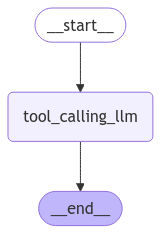

In [40]:
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END

# Node
def tool_calling_llm(state: MessagesState):
 return {"messages": [llm_with_tools.invoke(state['messages'])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
# llm without calling tools

messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi! How can I assist you today?


In [42]:
# llm calling tools
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiple (call_0czg)
 Call ID: call_0czg
  Args:
    a: 2
    b: 3
